In [1]:
import xarray as xr
import semopy as sm
from pcv.process import select_data
import pandas as pd
import numpy as np
from pcv.ds import create_xr_dataset, fill_xr_dataset
from pcv.models import *
import time
import os
import argparse
from pcv.cfg import IPCC_REGION_SHPFILE

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
t2m_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_t2m.nc"
tp_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_tp.nc"
ssrd_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_ssrd.nc"
lai_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_lai.nc"
swvlall_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_smroot.nc"
vpd_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_vpd.nc"
sd_path = "/data/compoundx/anand/PCV/data/detrended_seasonal_sd.nc"

t2m_data = xr.open_dataset(t2m_path)
tp_data = xr.open_dataset(tp_path)
ssrd_data = xr.open_dataset(ssrd_path)
swvlall_data = xr.open_dataset(swvlall_path)
vpd_data = xr.open_dataset(vpd_path)
sd_data = xr.open_dataset(sd_path)
lai_data = xr.open_dataset(lai_path)
lai_data = lai_data.reindex(lat = list(reversed(lai_data.lat)))

In [105]:
t2m_winter = select_data(t2m_data,  "winter")
t2m_spring = select_data(t2m_data,  "spring")
t2m_summer = select_data(t2m_data,  "summer")

tp_winter = select_data(tp_data,  "winter")
tp_spring = select_data(tp_data,  "spring")
tp_summer = select_data(tp_data,  "summer")

ssrd_winter = select_data(ssrd_data,  "winter")
ssrd_spring = select_data(ssrd_data,  "spring")
ssrd_summer = select_data(ssrd_data,  "summer")

lai_winter = select_data(lai_data,  "winter")
lai_spring = select_data(lai_data,  "spring")
lai_summer = select_data(lai_data,  "summer")

swvlall_winter = select_data(swvlall_data,  "winter")
swvlall_spring = select_data(swvlall_data,  "spring")
swvlall_summer = select_data(swvlall_data,  "summer")

vpd_winter = select_data(vpd_data,  "winter")
vpd_spring = select_data(vpd_data,  "spring")
vpd_summer = select_data(vpd_data,  "summer")


sd_winter = select_data(sd_data,  "winter")
sd_spring = select_data(sd_data,  "spring")
sd_summer = select_data(sd_data,  "summer")

t = lai_summer.quantile(0.1, dim="time")
lai_summer = xr.where(lai_summer<t, 1, 0)

xtreme = "low"

/home/anand/.conda/envs/pcv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [106]:
def read_clim_mask():
    clim_mask_path = "/data/compoundx/anand/PCV/data/clim_mask/"
    clim_files = [clim_mask_path + file for file in os.listdir(clim_mask_path) if ".npy" in file ]

    return [np.load(files) for files in clim_files], [files.split("/")[-1] for files in clim_files]

In [107]:

def read_land_use(year):
    if year < 2016:
        version = "2.0.7cds"
    else:
        version = "2.1.1"

    file_name = f"/data/compoundx/anand/PCV/data/CCI-LC/ESACCI-LC-L4-LCCS-Map-300m-P1Y-aggregated-0.500000Deg-{year}-v{version}.nc"
    return xr.open_dataset(file_name)

def majority_class_1_landuse():
    val = []
    for i in range(1992, 2019):
        data = read_land_use(i)
        val.append(data.interp(lat = lai_data.lat.data, lon = lai_data.lon.data, method = "nearest").majority_class_1.data)

    majority_class_1 = np.stack(val)

    lu_mc_1 = xr.DataArray(
        majority_class_1, dims = ["time", "lat", "lon"], coords = {
            "time" : np.arange(1992, 2019),
            "lat" : lai_data.lat.data,
            "lon" : lai_data.lon.data,
        }
    )
    return lu_mc_1

lu_mc_1 = majority_class_1_landuse()

In [108]:
def mask_crop_forest(lu_mc_1):

    last_year_lu = lu_mc_1[-1,:,:]
    
    mask_forest = ((last_year_lu>=40) & ((last_year_lu<110)))
    mask_crop = ((last_year_lu>=10) & ((last_year_lu<40)))

    return mask_forest.values, mask_crop.values



In [109]:
mask_forest, mask_crop = mask_crop_forest(lu_mc_1)
region_mask, region_name = read_clim_mask()


In [110]:
def flatten_groups(arr, region_mask, lu_mc_1):
    mask_crop, mask_forest = mask_crop_forest(lu_mc_1)

    region_crop = np.logical_and(region_mask, mask_crop)
    region_forest = np.logical_and(region_mask, mask_forest)
    
    # crop = copy.deepcopy(arr.values)
    # forest = copy.deepcopy(arr.values)

    return arr.values[:,region_crop==True].flatten(), arr.values[:,region_forest==True].flatten()

In [111]:
def prep_data(t2m_w, tp_w, t2m_sp, tp_sp, t2m_su, tp_su, lai_sp, lai_su):
    keep_index = np.logical_and(~np.isnan(lai_sp),~np.isnan(t2m_w) )
    Y = lai_su[keep_index]

    X_w = np.stack([t2m_w, tp_w, t2m_sp, tp_sp, t2m_su, tp_su], axis=1)
    X_w = X_w[keep_index]

    X = np.stack([t2m_sp, tp_sp, t2m_su, tp_su], axis=1)
    X = X[keep_index]

    return X, X_w, Y

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, average_precision_score, roc_auc_score

In [113]:
[(i, name)  for i, name in enumerate(region_name) if "Siberia" in name]

[(5, 'E.Siberia.npy'), (51, 'W.Siberia.npy')]

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from scipy.stats import chi2
from sklearn.metrics import f1_score

In [115]:
f1_crop_list = []
auc_crop_list = []
ap_crop_list = []
crop_index = []


f1_forest_list = []
auc_forest_list = []
ap_forest_list = []
forest_index = []

i = 0
j = 0
for clim_index, name in enumerate(region_name):
    
    t2m_w_crop, t2m_w_forest = flatten_groups(t2m_winter, region_mask[clim_index], lu_mc_1)
    tp_w_crop, tp_w_forest = flatten_groups(tp_winter, region_mask[clim_index], lu_mc_1)
    sm_w_crop, sm_w_forest = flatten_groups(swvlall_winter, region_mask[clim_index], lu_mc_1)
    sm_sp_crop, sm_sp_forest = flatten_groups(swvlall_spring, region_mask[clim_index], lu_mc_1)
    lai_sp_crop, lai_sp_forest = flatten_groups(lai_spring, region_mask[clim_index], lu_mc_1)
    sm_su_crop, sm_su_forest = flatten_groups(swvlall_summer, region_mask[clim_index], lu_mc_1)
    lai_su_crop, lai_su_forest = flatten_groups(lai_summer, region_mask[clim_index], lu_mc_1)
    
    if len(t2m_w_crop)>0:
        crop_index.append(clim_index)
        
        t2m_w_crop, t2m_w_forest = flatten_groups(t2m_winter, region_mask[clim_index], lu_mc_1)
        tp_w_crop, tp_w_forest = flatten_groups(tp_winter, region_mask[clim_index], lu_mc_1)

        t2m_sp_crop, t2m_sp_forest = flatten_groups(t2m_spring, region_mask[clim_index], lu_mc_1)
        tp_sp_crop, tp_sp_forest = flatten_groups(tp_spring, region_mask[clim_index], lu_mc_1)

        t2m_su_crop, t2m_su_forest = flatten_groups(t2m_summer, region_mask[clim_index], lu_mc_1)
        tp_su_crop, tp_su_forest = flatten_groups(tp_summer, region_mask[clim_index], lu_mc_1)

        lai_sp_crop, lai_sp_forest = flatten_groups(lai_spring, region_mask[clim_index], lu_mc_1)
        lai_su_crop, lai_su_forest = flatten_groups(lai_summer, region_mask[clim_index], lu_mc_1)

        print(lai_su_crop.shape, lai_su_forest.shape)

        ## CROP DATA

        X, X_w, Y = prep_data(t2m_w_crop, tp_w_crop, t2m_sp_crop, tp_sp_crop,t2m_su_crop, tp_su_crop, lai_sp_crop, lai_su_crop)

        clf_1 = LogisticRegression(random_state=42, class_weight="balanced", max_iter=500).fit(X, Y)
        clf_2 = LogisticRegression(random_state=42, class_weight="balanced", max_iter=500).fit(X_w, Y)

        print(f"######## CROP RESULTS for {region_name[clim_index][:-4]} with {lai_su_crop.shape[0]} points")

        max_f1 = 0
        for t in range(1,100):
            log_prob = clf_1.predict_proba(X)[:,1]
            y_pred = np.where(log_prob>t/100, 1, 0)
            max_f1 = max(f1_score(y_pred, Y), max_f1)
        print(max_f1)

        f1_crop_list.append([max_f1])
        auc_crop_list.append([roc_auc_score(Y, log_prob)])
        ap_crop_list.append([average_precision_score(Y, log_prob)])
    
        max_f1 = 0
        for t in range(1,100):
            log_prob_w = clf_2.predict_proba(X_w)[:,1]
            y_pred = np.where(log_prob_w>t/100, 1, 0)
            max_f1 = max(f1_score(y_pred, Y), max_f1)
        print(max_f1)

        f1_crop_list[i].append(max_f1)
        auc_crop_list[i].append([roc_auc_score(Y, log_prob)])
        ap_crop_list[i].append([average_precision_score(Y, log_prob)])
        i+=1

        # alt_ll = -log_loss(Y, log_prob_w, normalize=False)
        # null_ll = -log_loss(Y, log_prob, normalize=False)

        # G = 2*(alt_ll-null_ll)
        # df =  X_w.shape[1]-X.shape[1]
        # print(f"p-value {chi2.sf(G,df)}")


        ######## FOREST DATA
    if len(t2m_w_forest)>0:
        forest_index.append(clim_index)
        X, X_w, Y = prep_data(t2m_w_forest, tp_w_forest, t2m_sp_forest, tp_sp_forest,t2m_su_forest, tp_su_forest, lai_sp_forest, lai_su_forest)

        clf_1 = LogisticRegression(random_state=42, class_weight="balanced", max_iter=500).fit(X, Y)
        clf_2 = LogisticRegression(random_state=42, class_weight="balanced", max_iter=500).fit(X_w, Y)

        print(f"######## FOREST RESULTS for {region_name[clim_index]} with {lai_su_forest.shape[0]} points")
        max_f1 = 0
        for t in range(1,100):
            log_prob = clf_1.predict_proba(X)[:,1]
            y_pred = np.where(log_prob>t/100, 1, 0)
            max_f1 = max(f1_score(y_pred, Y), max_f1)
        print(max_f1)

        f1_forest_list.append([max_f1])
        auc_forest_list.append([roc_auc_score(Y, log_prob)])
        ap_forest_list.append([average_precision_score(Y, log_prob)])

        max_f1 = 0
        for t in range(1,100):
            log_prob_w = clf_2.predict_proba(X_w)[:,1]
            y_pred = np.where(log_prob_w>t/100, 1, 0)
            max_f1 = max(f1_score(y_pred, Y), max_f1)
        print(max_f1)

        f1_forest_list[j].append(max_f1)
        auc_forest_list[j].append([roc_auc_score(Y, log_prob)])
        ap_forest_list[j].append([average_precision_score(Y, log_prob)])
        j+=1
        # alt_ll = -log_loss(Y, log_prob_w, normalize=False)
        # null_ll = -log_loss(Y, log_prob, normalize=False)

        # G = 2*(alt_ll-null_ll)
        # df =  X_w.shape[1]-X.shape[1]
        # print(f"p-value {chi2.sf(G,df)}")

        # fig, ax = plt.subplots(1,1)
        # PrecisionRecallDisplay.from_estimator(clf_1, X, Y, ax=ax, color = "blue")
        # PrecisionRecallDisplay.from_estimator(clf_2, X_w, Y, ax=ax, color = "red")
        # plt.show()

        # fig, ax = plt.subplots(1,1)
        # RocCurveDisplay.from_estimator(clf_1, X, Y, ax=ax, color = "blue" )
        # RocCurveDisplay.from_estimator(clf_2, X_w, Y, ax=ax, color = "red")
        # plt.show()



(143792,) (24624,)
######## CROP RESULTS for W.North-America with 143792 points
0.2764137713078002
0.2789723274991906
######## FOREST RESULTS for W.North-America.npy with 24624 points
0.45685670261941447
0.49512091641917694
(138168,) (62624,)
######## CROP RESULTS for E.Siberia with 138168 points
0.23753894080996882
0.23251865275668968
######## FOREST RESULTS for E.Siberia.npy with 62624 points
0.3446429547068786
0.3461308715720879
(58482,) (0,)
######## CROP RESULTS for Tibetan-Plateau with 58482 points
0.3375596904330644
0.48933943754087633
(98344,) (122056,)
######## CROP RESULTS for Russian-Arctic with 98344 points
0.2499705501236895
0.264920784200246
######## FOREST RESULTS for Russian-Arctic.npy with 122056 points
0.24783752399459677
0.25281995145400027
(50920,) (158194,)
######## CROP RESULTS for West&Central-Europe with 50920 points
0.27069869528106333
0.2766557069046501
######## FOREST RESULTS for West&Central-Europe.npy with 158194 points
0.35595469828348963
0.354865808904806

In [116]:
def generate_shape_feature():
    ipcc_regions = shpreader.Reader(IPCC_REGION_SHPFILE)
    shape_feature_list = []
    for i, records in enumerate(ipcc_regions.records()):
        shape_feature = ShapelyFeature([records.geometry], ccrs.PlateCarree(), facecolor = "None", edgecolor='black', lw=1)
        shape_feature_list.append((records.attributes["Name"], shape_feature, (records.geometry.centroid.x, records.geometry.centroid.y) ))

    return shape_feature_list
shape_feature_list = generate_shape_feature()

In [117]:
def add_features_crop(ax, shape_feature_list):
    vmin = 0
    vmax = 0.05
    cmap = mpl.cm.Blues
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    for name, shape_feature, centroid in shape_feature_list:
        if 75>centroid[1]>15:
            for k, c_ind in enumerate(crop_index):
            
                if name==region_name[c_ind][:-4]:
                    dist = f1_crop_list[k][1]-f1_crop_list[k][0]


                    color = cmap(norm(dist))
                    
                    ax.add_feature(shape_feature, linestyle = "--", color=color)
                else:
                    ax.add_feature(shape_feature, linestyle = ":")
                    
                ax.set_extent((-180, 180, 25, 75), crs=ccrs.PlateCarree())
    return cmap, norm   
        # and name!="N.Pacific-Ocean":
            # ax.text(centroid[0], centroid[1], name, color='k', size=11, ha='center', va='center', wrap = True,  transform=ccrs.PlateCarree())


In [118]:
def add_features_forest(ax, shape_feature_list):
    vmin = 0
    vmax = 0.05
    cmap = mpl.cm.Greens
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    for name, shape_feature, centroid in shape_feature_list:
        if 75>centroid[1]>15:
            for k, c_ind in enumerate(forest_index):
            
                if name==region_name[c_ind][:-4]:
                    dist = f1_forest_list[k][1]-f1_forest_list[k][0]


                    color = cmap(norm(dist))
                    
                    ax.add_feature(shape_feature, linestyle = "--", color=color)
                    # ax.text(centroid[0], centroid[1], f"{np.round(dist,3)}", color='k', size=8, ha='center', va='center', wrap = True,  transform=ccrs.PlateCarree())
                else:
                    ax.add_feature(shape_feature, linestyle = ":")
                ax.set_extent((-180, 180, 25, 75), crs=ccrs.PlateCarree())

    return cmap, norm      

        # and name!="N.Pacific-Ocean":
            # 


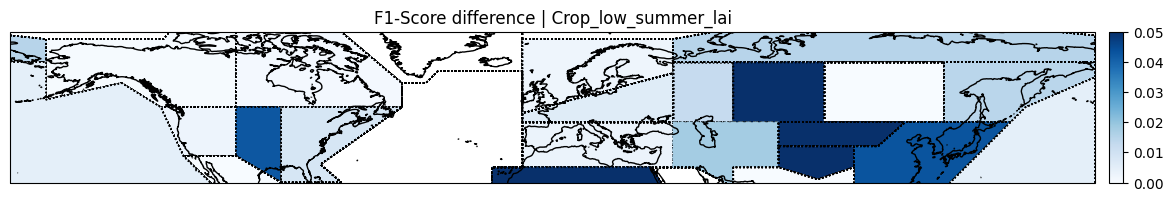

In [119]:
fig, ax = plt.subplots(1, 1, figsize = (14, 4), 
                subplot_kw={'projection': ccrs.PlateCarree()})

cmap, norm = add_features_crop(ax, shape_feature_list)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
ax.coastlines()

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0 
cax_width = 0.01
cax_height = axpos.height 
    #create new axes where the colorbar should go.
    #it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(sm, cax = pos_cax)
# plt.tight_layout()
ax.set_title(f"F1-Score difference | Crop_{xtreme}_summer_lai")
plt.savefig(f"Crop_{xtreme}_summer_lai.png", bbox_inches='tight')

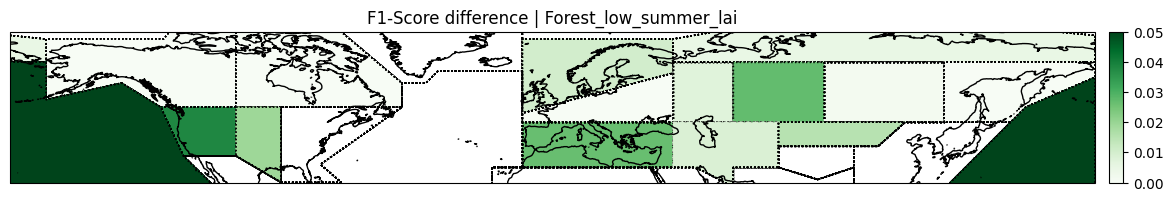

In [120]:
fig, ax= plt.subplots(1, 1, figsize = (14, 4), 
                subplot_kw={'projection': ccrs.PlateCarree()})



cmap, norm = add_features_forest(ax, shape_feature_list)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
ax.coastlines()

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
pos_y = axpos.y0 
cax_width = 0.01
cax_height = axpos.height 
    #create new axes where the colorbar should go.
    #it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(sm, cax = pos_cax)
# plt.tight_layout()
ax.set_title(f"F1-Score difference | Forest_{xtreme}_summer_lai")

plt.savefig(f"Forest_{xtreme}_summer_lai.png", bbox_inches='tight')

In [194]:
f1_crop_list, crop_index

([[0.23102854146378005, 0.2352603401395011],
  [0.2110824365778838, 0.21573199410100044],
  [0.3958450942757141, 0.42009435842913156],
  [0.20796238593367458, 0.21892620185231312],
  [0.24294129595774933, 0.24629672269552538],
  [0.2500262054507338, 0.26542489161620825],
  [0.384, 0.4166666666666667],
  [0.24013477612907405, 0.29340147301969033],
  [0.3123487984516961, 0.3160531220876049],
  [0.23202119606358823, 0.2528301886792453],
  [0.2017828510345881, 0.21346770499312873],
  [0.22179641592758864, 0.23555851324962088],
  [0.2399616061430171, 0.24745391802036867],
  [0.6138211382113822, 0.6997929606625259],
  [0.23521505376344082, 0.2606979642708766],
  [0.2734284484756198, 0.28289609280687805],
  [0.25821928408764294, 0.25710230327533923],
  [0.3204988897812633, 0.32566823004416917],
  [0.2217076700434153, 0.27615184004636334],
  [0.3564356435643565, 0.3947368421052632],
  [0.25869535694345946, 0.27362114537444937]],
 [4,
  5,
  9,
  11,
  12,
  17,
  20,
  21,
  23,
  24,
  26,
  

In [68]:
region_name[crop_index]

TypeError: list indices must be integers or slices, not list

In [50]:
f1_crop_list, crop_index

([[0.2764137713078002, 0.2789723274991906],
  [0.23753894080996882, 0.23251865275668968],
  [0.3375596904330644, 0.48933943754087633],
  [0.2499705501236895, 0.264920784200246],
  [0.27069869528106333, 0.2766557069046501],
  [0.2526851515251661, 0.295844238436514]],
 [])

In [670]:
clim_index = 51 #24  #57, 39  51, '47',  '39', '46',  43, 40,  32, 26, 24, 23, 21
t2m_w_crop, t2m_w_forest = flatten_groups(t2m_winter, region_mask[clim_index], lu_mc_1)
tp_w_crop, tp_w_forest = flatten_groups(tp_winter, region_mask[clim_index], lu_mc_1)

t2m_sp_crop, t2m_sp_forest = flatten_groups(t2m_spring, region_mask[clim_index], lu_mc_1)
tp_sp_crop, tp_sp_forest = flatten_groups(tp_spring, region_mask[clim_index], lu_mc_1)

t2m_su_crop, t2m_su_forest = flatten_groups(t2m_summer, region_mask[clim_index], lu_mc_1)
tp_su_crop, tp_su_forest = flatten_groups(tp_summer, region_mask[clim_index], lu_mc_1)

# sm_w_crop, sm_w_forest = flatten_groups(swvlall_winter, region_mask[clim_index], lu_mc_1)
# sm_sp_crop, sm_sp_forest = flatten_groups(swvlall_spring, region_mask[clim_index], lu_mc_1)
lai_sp_crop, lai_sp_forest = flatten_groups(lai_spring, region_mask[clim_index], lu_mc_1)
# sm_su_crop, sm_su_forest = flatten_groups(swvlall_summer, region_mask[clim_index], lu_mc_1)
lai_su_crop, lai_su_forest = flatten_groups(lai_summer, region_mask[clim_index], lu_mc_1)

print(lai_su_crop.shape, lai_su_forest.shape)

X, X_w, Y = prep_data(t2m_w_crop, tp_w_crop, t2m_sp_crop, tp_sp_crop,t2m_su_crop, tp_su_crop, lai_sp_crop, lai_su_crop)

clf_1 = LogisticRegression(random_state=42, class_weight="balanced", max_iter=500).fit(X, Y)
clf_2 = LogisticRegression(random_state=42, class_weight="balanced", max_iter=500).fit(X_w, Y)

print(f"######## CROP RESULTS for {region_name[clim_index][:-4]} with {lai_su_crop.shape[0]} points")

max_f1 = 0
for t in range(1,100):
    log_prob = clf_1.predict_proba(X)[:,1]
    y_pred = np.where(log_prob>t/100, 1, 0)
    max_f1 = max(f1_score(y_pred, Y), max_f1)
print(max_f1)

max_f1 = 0
for t in range(1,100):
    log_prob_w = clf_2.predict_proba(X_w)[:,1]
    y_pred = np.where(log_prob_w>t/100, 1, 0)
    max_f1 = max(f1_score(y_pred, Y), max_f1)
print(max_f1)

alt_ll = -log_loss(Y, log_prob_w, normalize=False)
null_ll = -log_loss(Y, log_prob, normalize=False)

G = 2*(alt_ll-null_ll)
df =  X_w.shape[1]-X.shape[1]
print(f"p-value {chi2.sf(G,df)}")

X, X_w, Y = prep_data(t2m_w_forest, tp_w_forest, t2m_sp_forest, tp_sp_forest,t2m_su_forest, tp_su_forest, lai_sp_forest, lai_su_forest)

clf_1 = LogisticRegression(random_state=42, class_weight="balanced", max_iter=500).fit(X, Y)
clf_2 = LogisticRegression(random_state=42, class_weight="balanced", max_iter=500).fit(X_w, Y)

print(f"######## FOREST RESULTS for {region_name[clim_index]} with {lai_su_forest.shape[0]} points")
max_f1 = 0
for t in range(1,100):
    log_prob = clf_1.predict_proba(X)[:,1]
    y_pred = np.where(log_prob>t/100, 1, 0)
    max_f1 = max(f1_score(y_pred, Y), max_f1)
print(max_f1)

max_f1 = 0
for t in range(1,100):
    log_prob_w = clf_2.predict_proba(X_w)[:,1]
    y_pred = np.where(log_prob_w>t/100, 1, 0)
    max_f1 = max(f1_score(y_pred, Y), max_f1)
print(max_f1)

alt_ll = -log_loss(Y, log_prob_w, normalize=False)
null_ll = -log_loss(Y, log_prob, normalize=False)

G = 2*(alt_ll-null_ll)
df =  X_w.shape[1]-X.shape[1]
print(f"p-value {chi2.sf(G,df)}")

fig, ax = plt.subplots(1,1)
PrecisionRecallDisplay.from_estimator(clf_1, X, Y, ax=ax, color = "blue")
PrecisionRecallDisplay.from_estimator(clf_2, X_w, Y, ax=ax, color = "red")
plt.show()

fig, ax = plt.subplots(1,1)
RocCurveDisplay.from_estimator(clf_1, X, Y, ax=ax, color = "blue" )
RocCurveDisplay.from_estimator(clf_2, X_w, Y, ax=ax, color = "red")
plt.show()


(22648,) (74480,)


######## CROP RESULTS for W.Siberia with 22648 points
0.260325406758448
0.3232049545190633
p-value 0.0


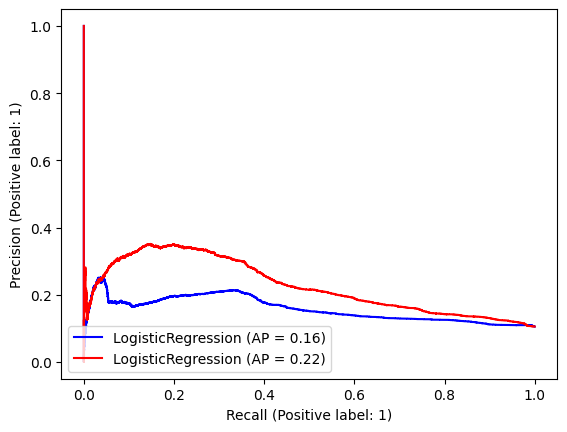

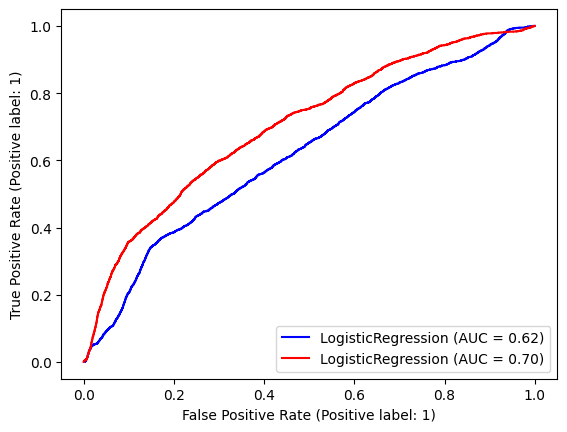

In [671]:
X, X_w, Y = prep_data(t2m_w_crop, tp_w_crop, t2m_sp_crop, tp_sp_crop,t2m_su_crop, tp_su_crop, lai_sp_crop, lai_su_crop)

clf_1 = LogisticRegression(random_state=42, class_weight="balanced", max_iter=500).fit(X, Y)
clf_2 = LogisticRegression(random_state=42, class_weight="balanced", max_iter=500).fit(X_w, Y)

print(f"######## CROP RESULTS for {region_name[clim_index][:-4]} with {lai_su_crop.shape[0]} points")

max_f1 = 0
for t in range(1,100):
    log_prob = clf_1.predict_proba(X)[:,1]
    y_pred = np.where(log_prob>t/100, 1, 0)
    max_f1 = max(f1_score(y_pred, Y), max_f1)
print(max_f1)

max_f1 = 0
for t in range(1,100):
    log_prob_w = clf_2.predict_proba(X_w)[:,1]
    y_pred = np.where(log_prob_w>t/100, 1, 0)
    max_f1 = max(f1_score(y_pred, Y), max_f1)
print(max_f1)

alt_ll = -log_loss(Y, log_prob_w, normalize=False)
null_ll = -log_loss(Y, log_prob, normalize=False)

G = 2*(alt_ll-null_ll)
df =  X_w.shape[1]-X.shape[1]
print(f"p-value {chi2.sf(G,df)}")

fig, ax = plt.subplots(1,1)
PrecisionRecallDisplay.from_estimator(clf_1, X, Y, ax=ax, color = "blue")
PrecisionRecallDisplay.from_estimator(clf_2, X_w, Y, ax=ax, color = "red")
plt.show()

fig, ax = plt.subplots(1,1)
RocCurveDisplay.from_estimator(clf_1, X, Y, ax=ax, color = "blue" )
RocCurveDisplay.from_estimator(clf_2, X_w, Y, ax=ax, color = "red")
plt.show()




######## FOREST RESULTS for W.Siberia.npy with 74480 points
0.431370328425821
0.4584205020920502
p-value 0.0


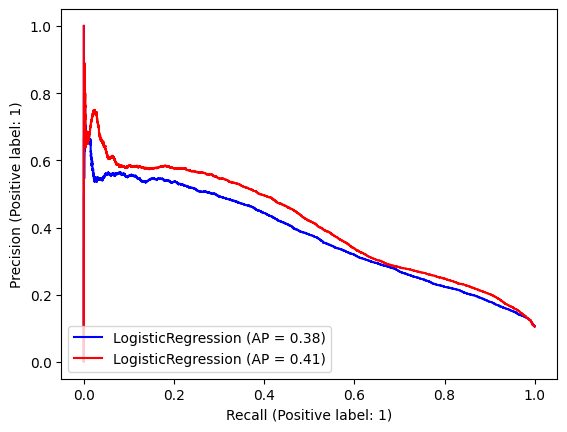

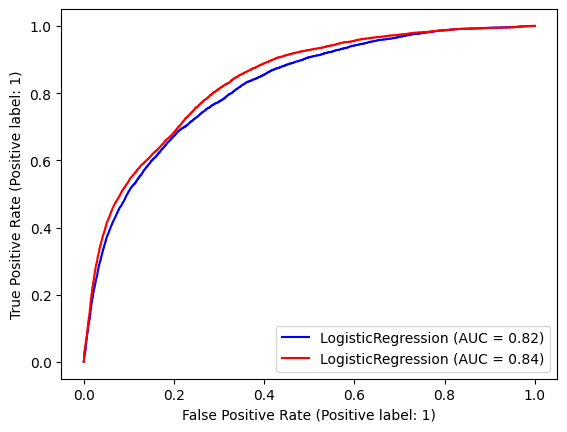

In [672]:
X, X_w, Y = prep_data(t2m_w_forest, tp_w_forest, t2m_sp_forest, tp_sp_forest,t2m_su_forest, tp_su_forest, lai_sp_forest, lai_su_forest)

clf_1 = LogisticRegression(random_state=42, class_weight="balanced", max_iter=500).fit(X, Y)
clf_2 = LogisticRegression(random_state=42, class_weight="balanced", max_iter=500).fit(X_w, Y)

print(f"######## FOREST RESULTS for {region_name[clim_index]} with {lai_su_forest.shape[0]} points")
max_f1 = 0
for t in range(1,100):
    log_prob = clf_1.predict_proba(X)[:,1]
    y_pred = np.where(log_prob>t/100, 1, 0)
    max_f1 = max(f1_score(y_pred, Y), max_f1)
print(max_f1)

max_f1 = 0
for t in range(1,100):
    log_prob_w = clf_2.predict_proba(X_w)[:,1]
    y_pred = np.where(log_prob_w>t/100, 1, 0)
    max_f1 = max(f1_score(y_pred, Y), max_f1)
print(max_f1)

alt_ll = -log_loss(Y, log_prob_w, normalize=False)
null_ll = -log_loss(Y, log_prob, normalize=False)

G = 2*(alt_ll-null_ll)
df =  X_w.shape[1]-X.shape[1]
print(f"p-value {chi2.sf(G,df)}")

fig, ax = plt.subplots(1,1)
PrecisionRecallDisplay.from_estimator(clf_1, X, Y, ax=ax, color = "blue")
PrecisionRecallDisplay.from_estimator(clf_2, X_w, Y, ax=ax, color = "red")
plt.show()

fig, ax = plt.subplots(1,1)
RocCurveDisplay.from_estimator(clf_1, X, Y, ax=ax, color = "blue" )
RocCurveDisplay.from_estimator(clf_2, X_w, Y, ax=ax, color = "red")
plt.show()

